### Setup

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 10.7 MB/s eta 0:00:00


In [ ]:
# Imports
import geemap
import ee
import pandas as pd
from sklearn.metrics import (
    precision_recall_curve,
    confusion_matrix,
    roc_curve,
    auc
)
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import rasterio
import numpy as np
import os
from matplotlib import colors
import matplotlib.patches as mpatches

# Mount your Google Drive
drive.mount("/content/drive")

# Constants
ASSET_PATH = f"projects/my-masters-thesis/assets/"

INPUT_LABEL_MAPPING = {
    "NBR": "NBR",
    "NDMI": "NDMI",
    "NDVI": "NDVI",
    "distance_to_rivers_sqrt": "Distance to River",
    "distance_to_roads_sqrt": "Distance to Roads",
    "distance_to_urban_sqrt": "Distance to Urban",
    "elevation": "Elevation",
    "precipitation": "Precipitation",
    "slope": "Slope",
    "temperature": "Temperature",
}

Mounted at /content/drive


In [ ]:
# Connect to earth engine
ee.Authenticate()
ee.Initialize(project="my-masters-thesis")

In [ ]:
# Display map
m = geemap.Map()
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Helper Functions

In [ ]:
# Retrieve a feature collection asset given its corresponding file_name
def retrieve_asset(file_name: str) -> ee.FeatureCollection:
    return ee.FeatureCollection(ASSET_PATH + file_name)

In [ ]:
# Retrieve an image asset given its corresponding file_name
def retrieve_image_asset(file_name: str) -> ee.Image:
    return ee.Image(ASSET_PATH + file_name)

In [ ]:
# Saves a provided feature collection as an asset
def save_as_asset(file_name: str, feature_collection: ee.FeatureCollection) -> None:
    task = ee.batch.Export.table.toAsset(
        collection=feature_collection, assetId=ASSET_PATH + file_name
    )

    task.start()

In [ ]:
# Saves a provided feature collection as an asset
def save_image_as_asset(file_name: str, image: ee.Image, region: ee.Geometry) -> None:
    task = ee.batch.Export.image.toAsset(
        image=image,
        assetId=ASSET_PATH + file_name,  # Path where the asset will be saved
        region=region,
        scale=300,
        crs="EPSG:4326",
    )

    task.start()

### Logic For Generating Regions & Output Fire Metrics

In [ ]:
# Get California's border to stay in proper scope
states = ee.FeatureCollection("TIGER/2018/States")
selected_states = states.filter(ee.Filter.inList("STUSPS", ["CA"]))

m.addLayer(selected_states, {"color": "red"}, "US States")

In [ ]:
# Filter region to include only Forests
dataset = ee.ImageCollection("MODIS/061/MCD12Q1").first()
igbpLandCover = dataset.select("LC_Type1")
forest_classes = list(map(lambda x: x, range(1, 12)))

# Create a binary mask for forest and woodland areas
forest_mask = igbpLandCover.remap(forest_classes, [1] * len(forest_classes)).selfMask()

# Clip the mask to California
forest_mask_california = forest_mask.clip(selected_states)
hh = selected_states.filterBounds(forest_mask.geometry())
vis_params = {"min": 0, "max": 1, "palette": ["white", "green"]}

# Add the forest mask to the map
m.addLayer(forest_mask_california, vis_params, "Forest and Woodland Areas")

In [ ]:
# Get where fires have happened in California from the start of 2017 to the end of 2018
data = ee.ImageCollection("ESA/CCI/FireCCI/5_1").filterDate("2017-01-01", "2018-12-31")
burned_data = data.select("BurnDate")

burned_data = burned_data.select(["BurnDate"], ["Burned"])

burned_area_mask = burned_data.map(lambda image: image.gt(0)).max()
burned_area_mask = burned_area_mask.unmask(0)
california_burn_2017_2018 = burned_area_mask.updateMask(forest_mask_california)

vis_params = {"min": 0, "max": 1, "palette": ["white", "black"]}

m.addLayer(california_burn_2017_2018, vis_params, "MODIS Fire 2017-2018")
save_image_as_asset(
    "output_for_2016", california_burn_2017_2018, selected_states.geometry()
)

In [ ]:
# Get where fires have happened in California through the start of 2019 to the end of 2020
data = ee.ImageCollection("ESA/CCI/FireCCI/5_1").filterDate("2019-01-01", "2020-12-31")
burned_data = data.select("BurnDate")

burned_data = burned_data.select(["BurnDate"], ["Burned"])

burned_area_mask = burned_data.map(lambda image: image.gt(0)).max()
burned_area_mask = burned_area_mask.unmask(0)
california_burn_2019_2020 = burned_area_mask.updateMask(forest_mask_california)

vis_params = {"min": 0, "max": 1, "palette": ["white", "black"]}

m.addLayer(california_burn_2019_2020, vis_params, "MODIS Fire 2019-2020")
save_image_as_asset(
    "output_for_2018", california_burn_2019_2020, selected_states.geometry()
)

### Logic For Generating Time Insensitive Input Data


In [ ]:
# Distance to Urban
urban_areas = (
    ee.Image("JRC/GHSL/P2023A/GHS_SMOD/2020")
    .clip(selected_states.geometry())
    .select("smod_code")
)
urban_areas = urban_areas.reproject(crs="EPSG:4326", scale=300)

values_of_interest = ee.List([22, 23, 30])
binary_mask = urban_areas.remap(
    values_of_interest, ee.List.repeat(1, values_of_interest.size())
).unmask(0)
m.addLayer(
    binary_mask,
    {"min": 0, "max": 1, "palette": ["white", "blue"]},
    "Binary Mask for Urban Areas",
)

distance_to_1 = binary_mask.fastDistanceTransform(10000)
distance_to_urban = distance_to_1.sqrt().rename("distance_to_urban_sqrt")

m.addLayer(
    distance_to_1,
    {"min": 0, "max": 10000, "palette": ["yellow", "red"]},
    "Distance to 1",
)
save_image_as_asset(
    "distance_to_urban_sqrt", distance_to_urban, selected_states.geometry()
)

In [ ]:
# Distance to Roads
roads = ee.FeatureCollection("TIGER/2016/Roads")
major_roads = roads.filter(ee.Filter.inList("rttyp", ["I", "U", "S"]))
buffered_roads = major_roads.map(lambda feature: feature.buffer(300))

background_roads = ee.Image().constant(0).clip(selected_states.geometry())
roads = (
    background_roads.paint(
        featureCollection=buffered_roads,  # The FeatureCollection to rasterize
        color=1,  # Use a constant color
    )
    .rename("binary_mask")
    .clip(selected_states.geometry())
)
# m.addLayer(roads, {'min': 0, 'max': 1, 'palette': ['white', 'black']}, 'Roads')

distance_to_1 = roads.fastDistanceTransform(10000)
distance_to_roads = distance_to_1.sqrt().rename("distance_to_roads_sqrt")

m.addLayer(
    distance_to_roads,
    {"min": 0, "max": 10000, "palette": ["yellow", "red"]},
    "Distance to 1",
)
save_image_as_asset(
    "distance_to_roads_sqrt", distance_to_roads, selected_states.geometry()
)

In [ ]:
# Elevation
elevation = ee.Image("USGS/NED").clip(selected_states.geometry())

vis_params = {
    "min": 0,
    "max": 3000,
    "palette": ["blue", "green", "yellow", "orange", "red"],
}

m.addLayer(elevation, vis_params, "Elevation")
save_image_as_asset("elevation", elevation, selected_states.geometry())

In [ ]:
# Slope Aspect
slope = ee.Image("USGS/SRTMGL1_003")
slope = ee.Terrain.slope(slope)
slope = slope.clip(selected_states.geometry())

m.addLayer(
    slope,
    {"min": 0, "max": 30, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Slope",
)
save_image_as_asset("slope", slope, selected_states.geometry())

In [ ]:
# Distance from River
rivers = ee.FeatureCollection("WWF/HydroSHEDS/v1/FreeFlowingRivers")
california_rivers = rivers.filterBounds(selected_states.geometry())
buffered_rivers = california_rivers.map(lambda feature: feature.buffer(300))

background_rivers = ee.Image().constant(0).clip(selected_states.geometry())
rivers = (
    background_rivers.paint(
        featureCollection=buffered_rivers,  # The FeatureCollection to rasterize
        color=1,  # Use a constant color
    )
    .rename("binary_mask")
    .clip(selected_states.geometry())
)

distance_to_1 = rivers.fastDistanceTransform(10000)
distance_to_rivers = distance_to_1.sqrt().rename("distance_to_rivers_sqrt")

distance_vis = {"min": 0, "max": 10000, "palette": ["yellow", "red"]}

m.addLayer(distance_to_rivers, distance_vis, "Distance to Nearest River")
save_image_as_asset(
    "distance_to_rivers_sqrt", distance_to_rivers, selected_states.geometry()
)

### Logic For Generating Input Data 2016

In [ ]:
# Rainfall
rainfall = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .filterDate("2016-01-01", "2016-12-31")
    .filterBounds(selected_states.geometry())
)
total_rainfall = rainfall.sum()
total_rainfall = total_rainfall.clip(selected_states.geometry())

m.addLayer(
    total_rainfall,
    {"min": 0, "max": 2000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Total Rainfall 2016",
)
save_image_as_asset("rainfall_2016", total_rainfall, selected_states.geometry())

In [ ]:
# Temperature
temperature_collection = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .select("LST_Day_1km")
    .filterDate("2016-01-01", "2016-12-31")
)
temperature = (
    temperature_collection.median()
    .clip(selected_states.geometry())
    .multiply(0.02)
    .subtract(273.15)
    .rename("temperature")
)

vis_params = {
    "min": -10,
    "max": 40,
    "palette": ["blue", "green", "yellow", "orange", "red"],
}

m.addLayer(temperature, vis_params, "Temperature 2016")
save_image_as_asset("temperature_2016", temperature, selected_states.geometry())

In [ ]:
# NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return image.addBands(ndvi)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2016-01-01", "2016-12-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

ndvi = add_ndvi(sentinel_2_mean).select("NDVI")

m.addLayer(ndvi, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDVI 2016")
save_image_as_asset("ndvi_2016", ndvi, selected_states.geometry())

In [ ]:
# NDMI
def add_ndmi(image):
    ndmi = image.normalizedDifference(["B8", "B11"]).rename("NDMI")
    return image.addBands(ndmi)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2016-01-01", "2016-12-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

ndmi = add_ndmi(sentinel_2_mean).select("NDMI")

m.addLayer(ndmi, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDMI 2016")
save_image_as_asset("ndmi_2016", ndmi, selected_states.geometry())

In [ ]:
# NBR
def add_nbr(image):
    nbr = image.normalizedDifference(["B8", "B12"]).rename("NBR")
    return image.addBands(nbr)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2016-01-01", "2016-12-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

nbr = add_nbr(sentinel_2_mean).select("NBR")

m.addLayer(nbr, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NBR 2016")
save_image_as_asset("nbr_2016", nbr, selected_states.geometry())

### Logic For Generating Input Data 2018

In [ ]:
# Rainfall
rainfall = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .filterDate("2018-01-01", "2018-12-31")
    .filterBounds(selected_states.geometry())
)
total_rainfall = rainfall.sum()
total_rainfall = total_rainfall.clip(selected_states.geometry())

m.addLayer(
    total_rainfall,
    {"min": 0, "max": 2000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Total Rainfall 2018",
)
save_image_as_asset("rainfall_2018", total_rainfall, selected_states.geometry())

In [ ]:
# Temperature
temperature_collection = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .select("LST_Day_1km")
    .filterDate("2018-01-01", "2018-12-31")
)
temperature = (
    temperature_collection.median()
    .clip(selected_states.geometry())
    .multiply(0.02)
    .subtract(273.15)
    .rename("temperature")
)

vis_params = {
    "min": -10,
    "max": 40,
    "palette": ["blue", "green", "yellow", "orange", "red"],
}

m.addLayer(temperature, vis_params, "Temperature 2018")
save_image_as_asset("temperature_2018", temperature, selected_states.geometry())

In [ ]:
# NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return image.addBands(ndvi)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2018-01-01", "2018-12-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

ndvi = add_ndvi(sentinel_2_mean).select("NDVI")

m.addLayer(ndvi, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDVI 2018")
save_image_as_asset("ndvi_2018", ndvi, selected_states.geometry())

In [ ]:
# NDMI
def add_ndmi(image):
    ndmi = image.normalizedDifference(["B8", "B11"]).rename("NDMI")
    return image.addBands(ndmi)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2018-01-01", "2018-12-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

ndmi = add_ndmi(sentinel_2_mean).select("NDMI")

m.addLayer(ndmi, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDMI 2018")
save_image_as_asset("ndmi_2018", ndmi, selected_states.geometry())

In [ ]:
# NBR
def add_nbr(image):
    nbr = image.normalizedDifference(["B8", "B12"]).rename("NBR")
    return image.addBands(nbr)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2018-01-01", "2018-12-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

nbr = add_nbr(sentinel_2_mean).select("NBR")

m.addLayer(nbr, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NBR 2018")
save_image_as_asset("nbr_2018", nbr, selected_states.geometry())

### Logic for Generating Input Data Current

In [ ]:
# Rainfall
rainfall = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .filterDate("2023-09-01", "2024-08-31")
    .filterBounds(selected_states.geometry())
)
total_rainfall = rainfall.sum()
total_rainfall = total_rainfall.clip(selected_states.geometry())

m.addLayer(
    total_rainfall,
    {"min": 0, "max": 2000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Total Rainfall Current",
)
save_image_as_asset("rainfall_current", total_rainfall, selected_states.geometry())

In [ ]:
# Temperature
temperature_collection = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .select("LST_Day_1km")
    .filterDate("2023-09-01", "2024-08-31")
)
temperature = (
    temperature_collection.median()
    .clip(selected_states.geometry())
    .multiply(0.02)
    .subtract(273.15)
    .rename("temperature")
)

vis_params = {
    "min": -10,
    "max": 40,
    "palette": ["blue", "green", "yellow", "orange", "red"],
}

m.addLayer(temperature, vis_params, "Temperature Current")
save_image_as_asset("temperature_current", temperature, selected_states.geometry())

In [ ]:
# NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return image.addBands(ndvi)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2023-09-01", "2024-08-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

ndvi = add_ndvi(sentinel_2_mean).select("NDVI")

m.addLayer(ndvi, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDVI Current")
save_image_as_asset("ndvi_current", ndvi, selected_states.geometry())

In [ ]:
# NDMI
def add_ndmi(image):
    ndmi = image.normalizedDifference(["B8", "B11"]).rename("NDMI")
    return image.addBands(ndmi)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2023-09-01", "2024-08-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

ndmi = add_ndmi(sentinel_2_mean).select("NDMI")

m.addLayer(ndmi, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDMI Current")
save_image_as_asset("ndmi_current", ndmi, selected_states.geometry())

In [ ]:
# NBR
def add_nbr(image):
    nbr = image.normalizedDifference(["B8", "B12"]).rename("NBR")
    return image.addBands(nbr)


sentinel_2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterDate(
    "2023-09-01", "2024-08-31"
)
sentinel_2_mean = sentinel_2.median().clip(selected_states.geometry())

nbr = add_nbr(sentinel_2_mean).select("NBR")

m.addLayer(nbr, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NBR Current")
save_image_as_asset("nbr_current", nbr, selected_states.geometry())

### Retrieve Saved Images



Time Insensitive Inputs

In [ ]:
img_urban = retrieve_image_asset("distance_to_urban_sqrt")
m.addLayer(
    img_urban, {"min": 0, "max": 150, "palette": ["red", "white"]}, "Distance to Urban"
)

In [ ]:
img_roads = retrieve_image_asset("distance_to_roads_sqrt")
m.addLayer(
    img_roads,
    {"min": 0, "max": 100, "palette": ["orange", "white"]},
    "Distance to Roads",
)

In [ ]:
img_elevation = retrieve_image_asset("elevation")
m.addLayer(
    img_elevation,
    {"min": 0, "max": 3000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Elevation",
)

In [ ]:
img_rivers = retrieve_image_asset("distance_to_rivers_sqrt")
m.addLayer(
    img_rivers,
    {"min": 0, "max": 20, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Rivers",
)

In [ ]:
img_slope = retrieve_image_asset("slope")
m.addLayer(
    img_slope,
    {"min": 0, "max": 40, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Slope",
)

Inputs 2016

In [ ]:
img_rainfall_2016 = retrieve_image_asset("rainfall_2016")
m.addLayer(
    img_rainfall_2016,
    {"min": 0, "max": 2000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Rainfall 2016",
)

In [ ]:
img_temperature_2016 = retrieve_image_asset("temperature_2016")
m.addLayer(
    img_temperature_2016,
    {"min": -10, "max": 40, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Temperature 2016",
)

In [ ]:
img_ndvi_2016 = retrieve_image_asset("ndvi_2016")
m.addLayer(
    img_ndvi_2016, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDVI 2016"
)

In [ ]:
img_ndmi_2016 = retrieve_image_asset("ndmi_2016")
m.addLayer(
    img_ndmi_2016,
    {"min": -0.2, "max": 1, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "NDMI 2016",
)

In [ ]:
img_nbr_2016 = retrieve_image_asset("nbr_2016")
m.addLayer(
    img_nbr_2016,
    {"min": -0.2, "max": 1, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "NBR 2016",
)

Inputs 2018

In [ ]:
img_rainfall_2018 = retrieve_image_asset("rainfall_2018")
m.addLayer(
    img_rainfall_2018,
    {"min": 0, "max": 2000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Rainfall 2018",
)

In [ ]:
img_temperature_2018 = retrieve_image_asset("temperature_2018")
m.addLayer(
    img_temperature_2018,
    {"min": -10, "max": 40, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Temperature 2018",
)

In [ ]:
img_ndvi_2018 = retrieve_image_asset("ndvi_2018")
m.addLayer(
    img_ndvi_2018, {"min": -0.2, "max": 1, "palette": ["white", "green"]}, "NDVI 2018"
)

In [ ]:
img_ndmi_2018 = retrieve_image_asset("ndmi_2018")
m.addLayer(
    img_ndmi_2018,
    {"min": -0.2, "max": 1, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "NDMI 2018",
)

In [ ]:
img_nbr_2018 = retrieve_image_asset("nbr_2018")
m.addLayer(
    img_nbr_2018,
    {"min": -0.2, "max": 1, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "NBR 2018",
)

Inputs Current

In [ ]:
img_rainfall_current = retrieve_image_asset("rainfall_current")
m.addLayer(
    img_rainfall_current,
    {"min": 0, "max": 2000, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Rainfall Current",
)

In [ ]:
img_temperature_current = retrieve_image_asset("temperature_current")
m.addLayer(
    img_temperature_current,
    {"min": -10, "max": 40, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "Temperature Current",
)

In [ ]:
img_ndvi_current = retrieve_image_asset("ndvi_current")
m.addLayer(
    img_ndvi_current,
    {"min": -0.2, "max": 1, "palette": ["white", "green"]},
    "NDVI Current",
)

In [ ]:
img_ndmi_current = retrieve_image_asset("ndmi_current")
m.addLayer(
    img_ndmi_current,
    {"min": -0.2, "max": 1, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "NDMI Current",
)

In [ ]:
img_nbr_current = retrieve_image_asset("nbr_current")
m.addLayer(
    img_nbr_current,
    {"min": -0.2, "max": 1, "palette": ["blue", "green", "yellow", "orange", "red"]},
    "NBR Current",
)

Outputs

In [ ]:
img_output_2016 = retrieve_image_asset("output_for_2016")
vis_params = {"min": 0, "max": 1, "palette": ["white", "black"]}

m.addLayer(img_output_2016, vis_params, "MODIS Fire 2017-2018")

In [ ]:
img_output_2018 = retrieve_image_asset("output_for_2018")
vis_params = {"min": 0, "max": 1, "palette": ["white", "black"]}

m.addLayer(img_output_2018, vis_params, "MODIS Fire 2019-2020")

Output Risk Maps

In [ ]:
rf_prob_map_2016 = retrieve_image_asset("Random_Forest_2016")
rf_prob_map_2018 = retrieve_image_asset("Random_Forest_2018")
rf_prob_map_current = retrieve_image_asset("Random_Forest_Current")

svm_prob_map_2016 = retrieve_image_asset("Support_Vector_Machine_2016")
svm_prob_map_2018 = retrieve_image_asset("Support_Vector_Machine_2018")

cart_prob_map_2016 = retrieve_image_asset("CART_2016")
cart_prob_map_2018 = retrieve_image_asset("CART_2018")

Ventura Images for Discussion

In [ ]:
rf_prob_map_2016_ventura = retrieve_image_asset("rf_prob_map_2016_ventura")
rf_prob_map_2018_ventura = retrieve_image_asset("rf_prob_map_2018_ventura")
burned_2017_ventura = retrieve_image_asset("burned_2017_ventura")

Palisades Fire

In [ ]:
rf_prob_map_current_palisades = retrieve_image_asset("risk_map_palisades")

### Build the 3 Models For 2016

In [ ]:
# Display map
m = geemap.Map()
m

In [ ]:
# Get probabilities for a test set and export to csv
def classify_and_save(
    file_name: str, classifier: ee.Classifier, data: ee.FeatureCollection
) -> None:
    data_classified = data.classify(classifier)

    export_task = ee.batch.Export.table.toDrive(
        collection=data_classified.select(["classification", "Burned"]),
        description=file_name,
        fileFormat="CSV",
    )

    export_task.start()

In [ ]:
# Build ROC curve with a given test set
def plot_roc_curve(file_name: str) -> Tuple[pd.Series, pd.Series]:
    data = pd.read_csv(f"/content/drive/MyDrive/{file_name}.csv")

    y_true = data["Burned"]
    y_scores = data["classification"]

    y_pred = (y_scores >= 0.5).astype(int)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot it
    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return y_true, y_pred

In [ ]:
# Generate Confusion Matrix
def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series) -> None:
    cm = confusion_matrix(y_true, y_pred)
    get_key_metrics(cm)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted Negative", "Predicted Positive"],
        yticklabels=["Actual Negative", "Actual Positive"],
    )

    # Chart Features
    plt.figure(figsize=(8, 6))
    plt.show()

In [ ]:
# Get Accuracy Precision Recall
def get_key_metrics(confusion_matrix: list) -> None:
    true_positive = confusion_matrix[1][1]
    false_positive = confusion_matrix[1][0]
    true_negative = confusion_matrix[0][0]
    false_negative = confusion_matrix[0][1]

    accuracy = (true_positive + true_negative) / (
        true_positive + false_positive + true_negative + false_positive
    )
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

In [ ]:
# Get Feature Importance From Model
def plot_feature_importance(classifier: ee.Classifier) -> None:

    importance_dict = classifier.explain().getInfo()["importance"]

    # Turn into pandas df for plotting
    df = pd.DataFrame(list(importance_dict.items()), columns=["Feature", "Importance"])

    # Normalize and Clean
    df["Importance"] = df["Importance"] / df["Importance"].sum()
    df = df.sort_values(by="Importance", ascending=False)
    df["Feature"] = df["Feature"].map(INPUT_LABEL_MAPPING)

    # Chart Feature
    plt.figure(figsize=(12, 4))
    sns.barplot(x="Feature", y="Importance", data=df, palette="Blues_d")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Normalized Feature Importance")
    plt.show()

In [ ]:
# Generate Risk Mapping Image
def display_risk_map(img: ee.Image, classifier: ee.Classifier, model_type: str) -> None:
    probability_img = img.select(inputs).classify(classifier)
    final_img = probability_img.updateMask(forest_mask_california)

    m.addLayer(
        final_img,
        {"min": 0, "max": 1, "palette": ["white", "green", "yellow", "orange", "red"]},
        f"{model_type} Risk Map",
    )

    return final_img

In [ ]:
# Print Color Coordinated Samples
def print_samples(samples: ee.FeatureCollection, name: str) -> None:
    burned_samples = samples.filter(ee.Filter.eq("Burned", 1))
    unburned_samples = samples.filter(ee.Filter.eq("Burned", 0))

    m.addLayer(burned_samples, {"color": "red"}, f"Burned Samples {name}")
    m.addLayer(unburned_samples, {"color": "green"}, f"Unburned Samples {name}")

In [ ]:
# Train Data for model from 2016
img = (
    img_output_2016.addBands(img_urban)
    .addBands(img_roads)
    .addBands(img_ndvi_2016)
    .addBands(img_elevation)
    .addBands(img_temperature_2016)
    .addBands(img_slope)
    .addBands(img_rainfall_2016)
    .addBands(img_rivers)
    .addBands(img_ndmi_2016)
    .addBands(img_nbr_2016)
)

In [ ]:
# Set up samples and band value constants
inputs = [
    "NBR",
    "NDMI",
    "NDVI",
    "distance_to_rivers_sqrt",
    "distance_to_roads_sqrt",
    "distance_to_urban_sqrt",
    "elevation",
    "precipitation",
    "slope",
    "temperature",
]
output = "Burned"

samples = img.stratifiedSample(
    numPoints=500, classBand=output, region=hh, scale=300, geometries=True
)

samples.size().getInfo()

In [ ]:
# Split into train test split
samples_with_random = samples.randomColumn(columnName="random")
split_ratio = 0.7

training_set = samples_with_random.filter(ee.Filter.lt("random", split_ratio))
test_set = samples_with_random.filter(ee.Filter.gte("random", split_ratio))

# Ensure ratio is as expected
print(f"Training Samples: {training_set.size().getInfo()}")
print(f"Testing Samples: {test_set.size().getInfo()}")

In [ ]:
# Model 1: Random Forest Classifier
rf_classifier = (
    ee.Classifier.smileRandomForest(numberOfTrees=100)
    .setOutputMode("PROBABILITY")
    .train(features=training_set, classProperty=output, inputProperties=inputs)
)
rf_file_name = "2016_rf_prob"

# This may take a minute (so the next cell might not work immediately)
# classify_and_save(rf_file_name, rf_classifier, test_set)

In [ ]:
y_true, y_pred = plot_roc_curve(rf_file_name)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importance(rf_classifier)
display_risk_map(img, rf_classifier, "Random_Forest_2016")

In [ ]:
# Model 2: CART Classifier
cart_classifier = (
    ee.Classifier.smileCart()
    .setOutputMode("PROBABILITY")
    .train(features=training_set, classProperty=output, inputProperties=inputs)
)
cart_file_name = "2016_cart_prob"

# This may take a minute (so the next cell might not work immediately)
# classify_and_save(cart_file_name, cart_classifier, test_set)

In [ ]:
y_true, y_pred = plot_roc_curve(cart_file_name)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importance(cart_classifier)
display_risk_map(img, cart_classifier, "CART_2016")

In [ ]:
# Model 3: Support Vector Machine Classifier
svm_classifier = (
    ee.Classifier.libsvm()
    .setOutputMode("PROBABILITY")
    .train(features=training_set, classProperty=output, inputProperties=inputs)
)
svm_file_name = "2016_svm_prob"

# This may take a minute (so the next cell might not work immediately)
# classify_and_save(svm_file_name, svm_classifier, test_set)

In [ ]:
y_true, y_pred = plot_roc_curve(svm_file_name)
plot_confusion_matrix(y_true, y_pred)
# plot_feature_importance(svm_classifier) NO FEATURE IMPORTANCE FOR SVM
display_risk_map(img, svm_classifier, "Support_Vector_Machine_2016")

### Test Models on 2018 Data

In [ ]:
# Display map
m = geemap.Map()
m

In [ ]:
img_2018 = (
    img_output_2018.addBands(img_urban)
    .addBands(img_roads)
    .addBands(img_ndvi_2018)
    .addBands(img_elevation)
    .addBands(img_temperature_2018)
    .addBands(img_slope)
    .addBands(img_rainfall_2018)
    .addBands(img_rivers)
    .addBands(img_ndmi_2018)
    .addBands(img_nbr_2018)
)

In [ ]:
samples_2018 = img_2018.stratifiedSample(
    numPoints=150, classBand=output, region=hh, scale=300, geometries=True
)


samples_2018.size().getInfo()

In [ ]:
# Model 1: Random Forest Classifier
rf_file_name_2018 = "2018_rf_prob"

# This may take a minute (so the next cell might not work immediately)
# classify_and_save(rf_file_name_2018, rf_classifier, samples_2018)

In [ ]:
y_true, y_pred = plot_roc_curve(rf_file_name_2018)
plot_confusion_matrix(y_true, y_pred)
display_risk_map(img_2018, rf_classifier, "Random_Forest_2018")

In [ ]:
# Model 2: CART Classifier
cart_file_name_2018 = "2018_cart_prob"

# This may take a minute (so the next cell might not work immediately)
# classify_and_save(cart_file_name_2018, cart_classifier, samples_2018)

In [ ]:
y_true, y_pred = plot_roc_curve(cart_file_name_2018)
plot_confusion_matrix(y_true, y_pred)
display_risk_map(img_2018, cart_classifier, "CART_2018")

In [ ]:
# Model 3: SVM Classifier
svm_file_name_2018 = "2018_svm_prob"

# This may take a minute (so the next cell might not work immediately)
# classify_and_save(svm_file_name_2018, svm_classifier, samples_2018)

In [ ]:
y_true, y_pred = plot_roc_curve(svm_file_name_2018)
plot_confusion_matrix(y_true, y_pred)
display_risk_map(img_2018, svm_classifier, "Support_Vector_Machine_2018")

### Get Map of Current Data using the Random Forest Model

In [ ]:
# Display map
m = geemap.Map()
m

In [ ]:
img_current = (
    img_urban.addBands(img_roads)
    .addBands(img_ndvi_current)
    .addBands(img_elevation)
    .addBands(img_temperature_current)
    .addBands(img_slope)
    .addBands(img_rainfall_current)
    .addBands(img_rivers)
    .addBands(img_ndmi_current)
    .addBands(img_nbr_current)
)

In [ ]:
image_current_probs = display_risk_map(
    img_current, rf_classifier, "Random_Forest_Current"
)

In [ ]:
# For area calculations
def get_area_of_region(img: ee.Image) -> float:
    pixelArea = ee.Image.pixelArea()

    unmaskedArea = pixelArea.updateMask(img.mask()).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=img.geometry(), scale=300, maxPixels=1e10
    )

    area_in_square_meters = unmaskedArea.get("area").getInfo()
    return area_in_square_meters / (1 * 10**6)

In [ ]:
# Get area of region with high likelihood of fire and total area of forest
def get_area_risk_stats(
    image_current_probs: ee.image, min: float, max: float, name: str
) -> None:
    image = image_current_probs.select("classification")
    mask = image.gt(min).And(image.lte(max))
    masked_image_current_probs = image_current_probs.updateMask(mask)

    area_in_square_kilometers_total = get_area_of_region(image_current_probs)
    area_in_square_kilometers_fire = get_area_of_region(masked_image_current_probs)

    print(
        f"Total California Forested Area Analyzed (km^2): {area_in_square_kilometers_total}"
    )
    print(
        f"California Forested Area At {name} Risk (km^2): {area_in_square_kilometers_fire}"
    )
    print(
        f"% of Forest at {name} Risk: {(area_in_square_kilometers_fire / area_in_square_kilometers_total) * 100}%"
    )

In [ ]:
get_area_risk_stats(image_current_probs, 0.8, 1.0, "Very High")

In [ ]:
get_area_risk_stats(image_current_probs, 0.6, 0.8, "High")

In [ ]:
get_area_risk_stats(image_current_probs, 0.4, 0.6, "Medium")

In [ ]:
get_area_risk_stats(image_current_probs, 0.2, 0.4, "Low")

In [ ]:
get_area_risk_stats(image_current_probs, 0, 0.2, "Very Low")

### Ventura Region Processing

In [ ]:
# Display map
m = geemap.Map()
m

In [ ]:
# Things to Note 2016 and 2018 models look slightly different (likely because of the fires that occur in 2017)
# Note how the black spots here are unlikely predicted fire spots for 2018 but some are in 2016
data = ee.ImageCollection("ESA/CCI/FireCCI/5_1").filterDate("2017-01-01", "2017-12-31")
burned_data = data.select("BurnDate")

burned_data = burned_data.select(["BurnDate"], ["Burned"])

burned_area_mask = burned_data.map(lambda image: image.gt(0)).max()
burned_area_mask = burned_area_mask.unmask(0)
california_burn_2017 = burned_area_mask.updateMask(forest_mask_california)

vis_params = {"min": 0, "max": 1, "palette": ["white", "black"]}


ventura_coords = [-119.2921, 34.1746]


ventura_geometry = ee.Geometry.Rectangle(
    [
        ventura_coords[0] - 0.5,
        ventura_coords[1],
        ventura_coords[0] + 0.5,
        ventura_coords[1] + 0.5,
    ]
)
california_burn_2017 = california_burn_2017.clip(ventura_geometry)
m.addLayer(california_burn_2017, vis_params, "MODIS Fire 2017")

# save_image_as_asset("burned_2017_ventura", california_burn_2017, ventura_geometry)

In [ ]:
# Get the same region for the burned areas
rf_prob_map_2016_ventura = rf_prob_map_2016.clip(ventura_geometry)
m.addLayer(
    rf_prob_map_2016_ventura,
    {"min": 0, "max": 1, "palette": ["white", "green", "yellow", "orange", "red"]},
    f"2016 Risk Map",
)
# save_image_as_asset("rf_prob_map_2016_ventura", rf_prob_map_2016_ventura, ventura_geometry)


rf_prob_map_2018_ventura = rf_prob_map_2018.clip(ventura_geometry)
m.addLayer(
    rf_prob_map_2018_ventura,
    {"min": 0, "max": 1, "palette": ["white", "green", "yellow", "orange", "red"]},
    f"2018 Risk Map",
)
# save_image_as_asset("rf_prob_map_2018_ventura", rf_prob_map_2018_ventura, ventura_geometry)

### Palisades Region Processing

In [ ]:
palisades_coords = [-118.7, 34.0346]

palisades_geometry = ee.Geometry.Rectangle(
    [
        palisades_coords[0],
        palisades_coords[1],
        palisades_coords[0] + .2,
        palisades_coords[1] + .1,
    ]
)
m.addLayer(palisades_geometry, {}, "palisades")

rf_prob_map_current_palisades = rf_prob_map_current.clip(palisades_geometry)

save_image_as_asset("risk_map_palisades", rf_prob_map_current_palisades, palisades_geometry)

### Plotting for Paper and Documentation

In [ ]:
# Exporting Key Images to Drive for Plotting Purposes
# Image path = /content/drive/MyDrive/{file_name}.csv


def export_images_to_drive(
    img: ee.Image, folder_name: str, file_name: str, description: str
) -> None:
    task = ee.batch.Export.image.toDrive(
        image=img,
        description=description,
        folder=folder_name,
        fileNamePrefix=file_name,
        region=selected_states.geometry(),
        scale=300,
        fileFormat="GeoTIFF",
        crs="EPSG:4326",
        maxPixels=1e8,
    )
    task.start()

In [ ]:
# Plot pictures with color bar on
def plot_images_for_paper(
    folder_name: str,
    tiff_path: str,
    png_path: str,
    cmap_str: str,
    max_value: float = None,
) -> None:
    # Read tiff file with rasterio
    tiff_file = f"/content/drive/MyDrive/{folder_name}/{tiff_path}.tif"
    with rasterio.open(tiff_file) as src:
        data = src.read(1)

        if max_value:
            data = np.clip(data, a_min=None, a_max=max_value)

        fig, ax = plt.subplots()
        cmap = plt.get_cmap(cmap_str)
        plt.set_cmap(cmap)
        plt.axis("off")
        im = ax.imshow(data)
        plt.colorbar(im, ax=ax, shrink=0.9)
        plt.savefig(
            f"/content/drive/MyDrive/{folder_name}/{png_path}.png",
            format="png",
            bbox_inches="tight",
            pad_inches=0.2,
        )
        plt.close()

In [ ]:
def plot_output_images_for_paper(
    folder_name: str,
    tiff_path: str,
    png_path: str,
    cmap_str: str,
    max_value: float = None,
) -> None:
    # Read tiff file with rasterio
    tiff_file = f"/content/drive/MyDrive/{folder_name}/{tiff_path}.tif"
    with rasterio.open(tiff_file) as src:
        data = src.read(1)

        cmap = colors.ListedColormap(["white", "black", "grey"])

        fig, ax = plt.subplots()
        plt.axis("off")
        im = ax.imshow(data, cmap=cmap)
        grey_patch = mpatches.Patch(color="grey", label="Unburned")
        black_patch = mpatches.Patch(color="black", label="Burned")
        plt.legend(handles=[grey_patch, black_patch])

        plt.savefig(
            f"/content/drive/MyDrive/{folder_name}/{png_path}.png",
            format="png",
            bbox_inches="tight",
            pad_inches=0.2,
        )
        plt.close()

In [ ]:
# Plot pictures with color bar on
def plot_classifier_images_for_paper(
    folder_name: str,
    tiff_path: str,
    png_path: str,
    cmap_str: str,
    max_value: float = None,
) -> None:
    # Read tiff file with rasterio
    tiff_file = f"/content/drive/MyDrive/{folder_name}/{tiff_path}.tif"
    with rasterio.open(tiff_file) as src:
        data = src.read(1)

        if max_value:
            data = np.clip(data, a_min=None, a_max=max_value)

        fig, ax = plt.subplots()
        cmap = plt.get_cmap(cmap_str)
        plt.set_cmap(cmap)
        plt.axis("off")
        im = ax.imshow(data)
        cbar = plt.colorbar(im, ax=ax, shrink=0.9)
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
        plt.savefig(
            f"/content/drive/MyDrive/{folder_name}/{png_path}.png",
            format="png",
            bbox_inches="tight",
            pad_inches=0.2,
        )
        plt.close()

In [ ]:
task_list_inputs_2016 = [
    {
        "image": img_urban,
        "folder_name": "Thesis",
        "file_name": "img_urban",
        "description": "Save urban",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_roads,
        "folder_name": "Thesis",
        "file_name": "img_roads",
        "description": "Save roads",
        "cmap": "gist_earth",
        "max": 100,
    },
    {
        "image": img_elevation,
        "folder_name": "Thesis",
        "file_name": "img_elevation",
        "description": "Save elevation",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_slope,
        "folder_name": "Thesis",
        "file_name": "img_slope",
        "description": "Save slope",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_rivers,
        "folder_name": "Thesis",
        "file_name": "img_rivers",
        "description": "Save rivers",
        "cmap": "gist_earth",
        "max": 20,
    },
    {
        "image": img_ndvi_2016,
        "folder_name": "Thesis",
        "file_name": "img_ndvi_2016",
        "description": "Save ndvi_2016",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_temperature_2016,
        "folder_name": "Thesis",
        "file_name": "img_temperature_2016",
        "description": "Save temperature_2016",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_rainfall_2016,
        "folder_name": "Thesis",
        "file_name": "img_rainfall_2016",
        "description": "Save rainfall_2016",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_ndmi_2016,
        "folder_name": "Thesis",
        "file_name": "img_ndmi_2016",
        "description": "Save ndmi_2016",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_nbr_2016,
        "folder_name": "Thesis",
        "file_name": "img_nbr_2016",
        "description": "Save nbr_2016",
        "cmap": "gist_earth",
        "max": None,
    },
]

task_list_inputs_2018 = [
    {
        "image": img_urban,
        "folder_name": "Thesis",
        "file_name": "img_urban",
        "description": "Save urban",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_roads,
        "folder_name": "Thesis",
        "file_name": "img_roads",
        "description": "Save roads",
        "cmap": "gist_earth",
        "max": 100,
    },
    {
        "image": img_elevation,
        "folder_name": "Thesis",
        "file_name": "img_elevation",
        "description": "Save elevation",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_slope,
        "folder_name": "Thesis",
        "file_name": "img_slope",
        "description": "Save slope",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_rivers,
        "folder_name": "Thesis",
        "file_name": "img_rivers",
        "description": "Save rivers",
        "cmap": "gist_earth",
        "max": 20,
    },
    {
        "image": img_ndvi_2018,
        "folder_name": "Thesis",
        "file_name": "img_ndvi_2018",
        "description": "Save ndvi_2018",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_temperature_2018,
        "folder_name": "Thesis",
        "file_name": "img_temperature_2018",
        "description": "Save temperature_2018",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_rainfall_2018,
        "folder_name": "Thesis",
        "file_name": "img_rainfall_2018",
        "description": "Save rainfall_2018",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_ndmi_2018,
        "folder_name": "Thesis",
        "file_name": "img_ndmi_2018",
        "description": "Save ndmi_2018",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_nbr_2018,
        "folder_name": "Thesis",
        "file_name": "img_nbr_2018",
        "description": "Save nbr_2018",
        "cmap": "gist_earth",
        "max": None,
    },
]

task_list_inputs_current = [
    {
        "image": img_urban,
        "folder_name": "Thesis",
        "file_name": "img_urban",
        "description": "Save urban",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_roads,
        "folder_name": "Thesis",
        "file_name": "img_roads",
        "description": "Save roads",
        "cmap": "gist_earth",
        "max": 100,
    },
    {
        "image": img_elevation,
        "folder_name": "Thesis",
        "file_name": "img_elevation",
        "description": "Save elevation",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_slope,
        "folder_name": "Thesis",
        "file_name": "img_slope",
        "description": "Save slope",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_rivers,
        "folder_name": "Thesis",
        "file_name": "img_rivers",
        "description": "Save rivers",
        "cmap": "gist_earth",
        "max": 20,
    },
    {
        "image": img_ndvi_current,
        "folder_name": "Thesis",
        "file_name": "img_ndvi_current",
        "description": "Save ndvi_current",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_temperature_current,
        "folder_name": "Thesis",
        "file_name": "img_temperature_current",
        "description": "Save temperature_current",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_rainfall_current,
        "folder_name": "Thesis",
        "file_name": "img_rainfall_current",
        "description": "Save rainfall_current",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_ndmi_current,
        "folder_name": "Thesis",
        "file_name": "img_ndmi_current",
        "description": "Save ndmi_current",
        "cmap": "gist_earth",
        "max": None,
    },
    {
        "image": img_nbr_current,
        "folder_name": "Thesis",
        "file_name": "img_nbr_current",
        "description": "Save nbr_current",
        "cmap": "gist_earth",
        "max": None,
    },
]

output_images = [
    {
        "image": img_output_2016.where(img_output_2016.eq(0), 2),
        "folder_name": "Thesis",
        "file_name": "img_output_2016",
        "description": "Save output_2016",
        "cmap": "Pastel1",
        "max": None,
    },
    {
        "image": img_output_2018.where(img_output_2018.eq(0), 2),
        "folder_name": "Thesis",
        "file_name": "img_output_2018",
        "description": "Save output_2018",
        "cmap": "Pastel1",
        "max": None,
    },
]

classifier_images = [
    {
        "image": rf_prob_map_2016,
        "folder_name": "Thesis",
        "file_name": "img_rf_prob_map_2016",
        "description": "Save rf_prob_map_2016",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": rf_prob_map_2018,
        "folder_name": "Thesis",
        "file_name": "img_rf_prob_map_2018",
        "description": "Save rf_prob_map_2018",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": rf_prob_map_current,
        "folder_name": "Thesis",
        "file_name": "img_rf_prob_map_current",
        "description": "Save rf_prob_map_current",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": svm_prob_map_2016,
        "folder_name": "Thesis",
        "file_name": "img_svm_prob_map_2016",
        "description": "Save svm_prob_map_2016",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": svm_prob_map_2018,
        "folder_name": "Thesis",
        "file_name": "img_svm_prob_map_2018",
        "description": "Save svm_prob_map_2018",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": cart_prob_map_2016,
        "folder_name": "Thesis",
        "file_name": "img_cart_prob_map_2016",
        "description": "Save cart_prob_map_2016",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": cart_prob_map_2018,
        "folder_name": "Thesis",
        "file_name": "img_cart_prob_map_2018",
        "description": "Save cart_prob_map_2018",
        "cmap": "turbo",
        "max": None,
    },
]

classifier_images_ventura = [
    {
        "image": rf_prob_map_2016_ventura,
        "folder_name": "Thesis",
        "file_name": "img_rf_prob_map_2016_ventura",
        "description": "Save rf_prob_map_2016_ventura",
        "cmap": "turbo",
        "max": None,
    },
    {
        "image": rf_prob_map_2018_ventura,
        "folder_name": "Thesis",
        "file_name": "img_rf_prob_map_2018_ventura",
        "description": "Save rf_prob_map_2018_ventura",
        "cmap": "turbo",
        "max": None,
    },
]

output_ventura = [
    {
        "image": burned_2017_ventura.where(img_output_2016.eq(0), 2),
        "folder_name": "Thesis",
        "file_name": "img_output_for_2016_ventura",
        "description": "Save output_for_2016_ventura",
        "cmap": "Pastel1",
        "max": None,
    },
]

classifier_images_palisades = [
    {
        "image": rf_prob_map_current_palisades,
        "folder_name": "Thesis",
        "file_name": "img_rf_prob_map_current_palisades",
        "description": "Save rf_prob_map_current_palisades",
        "cmap": "turbo",
        "max": None,
    },
]

In [ ]:
# Run task for all images in task list to save the tiff in drive
for task in classifier_images_palisades:
    export_images_to_drive(
        task["image"],
        task["folder_name"],
        task["file_name"] + "_tiff",
        task["description"],
    )

In [ ]:
# Make sure each already exists in Drive before running
from matplotlib.colors import LinearSegmentedColormap

for task in classifier_images_palisades:
    # plot_images_for_paper(task["folder_name"], task["file_name"] + "_tiff", task["file_name"] + "_png", task["cmap"], task["max"])
    # plot_output_images_for_paper(task["folder_name"], task["file_name"] + "_tiff", task["file_name"] + "_png", task["cmap"], task["max"])
    plot_classifier_images_for_paper(
        task["folder_name"],
        task["file_name"] + "_tiff",
        task["file_name"] + "_png",
        task["cmap"],
        task["max"],
    )

In [ ]:
# All ROC Curves on 1 graph
def plot_roc_curves(info_list: list, title: str, output_file_name: str) -> None:
    # Plot it
    plt.figure()

    for info in info_list:
        data = pd.read_csv(f'/content/drive/MyDrive/{info["file_name"]}.csv')

        y_true = data["Burned"]
        y_scores = data["classification"]

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr,
            tpr,
            lw=2,
            color=info["color"],
            label=f'{info["name"]} (AUC = {roc_auc:.2f})',
        )

    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(
        f"/content/drive/MyDrive/Thesis/ROC Curves/{output_file_name}.png",
        format="png",
        bbox_inches="tight",
        pad_inches=0.2,
    )
    plt.show()

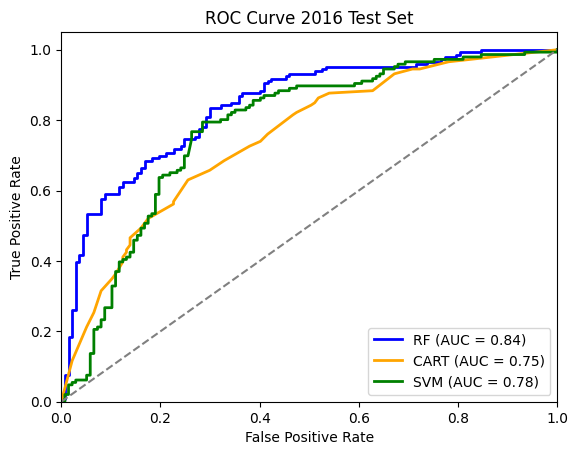

In [ ]:
roc_list_2016 = [
    {"file_name": "2016_rf_prob", "color": "blue", "name": "RF"},
    {"file_name": "2016_cart_prob", "color": "orange", "name": "CART"},
    {"file_name": "2016_svm_prob", "color": "green", "name": "SVM"},
]
plot_roc_curves(roc_list_2016, "ROC Curve 2016 Test Set", "roc_2016")

# file_name_list_2018 = ["2018_rf_prob", "2018_cart_prob", "2018_svm_prob"]
# plot_roc_curves(file_name_list_2018)

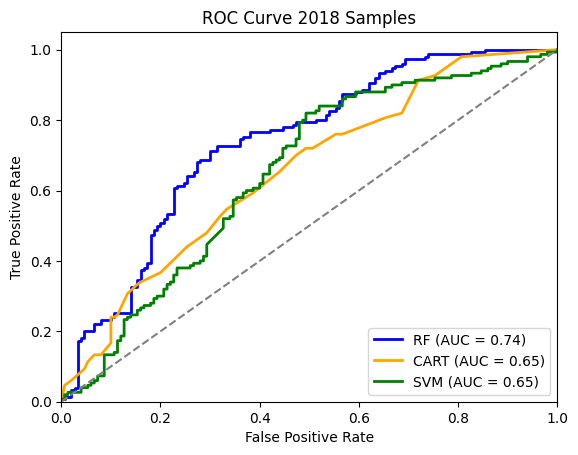

In [ ]:
roc_list_2018 = [
    {"file_name": "2018_rf_prob", "color": "blue", "name": "RF"},
    {"file_name": "2018_cart_prob", "color": "orange", "name": "CART"},
    {"file_name": "2018_svm_prob", "color": "green", "name": "SVM"},
]
plot_roc_curves(roc_list_2018, "ROC Curve 2018 Samples", "roc_2018")

In [ ]:
def plot_confusion_matrix_given_threshold(file_name: str, threshold: float) -> None:
    data = pd.read_csv(f"/content/drive/MyDrive/{file_name}.csv")

    y_true = data["Burned"]
    y_scores = data["classification"]

    y_pred = (y_scores >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    true_positive = cm[1][1]
    false_positive = cm[0][1]
    true_negative = cm[0][0]
    false_negative = cm[1][0]

    accuracy = (true_positive + true_negative) / (
        true_positive + false_positive + true_negative + false_negative
    )
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted Negative", "Predicted Positive"],
        yticklabels=["Actual Negative", "Actual Positive"],
    )
    # Chart Features
    plt.title(file_name + " " + str(threshold))
    plt.figure(figsize=(8, 6))
    plt.show()

In [ ]:
# 2016
file_names = ["2016_rf_prob", "2016_cart_prob", "2016_svm_prob"]
thresholds = [0.75]  # High / Very High Risk

for file_name in file_names:
    for threshold in thresholds:
        plot_confusion_matrix_given_threshold(file_name, threshold)

Accuracy: 0.5066666666666667
Precision: 0.5833333333333334
Recall: 0.04666666666666667


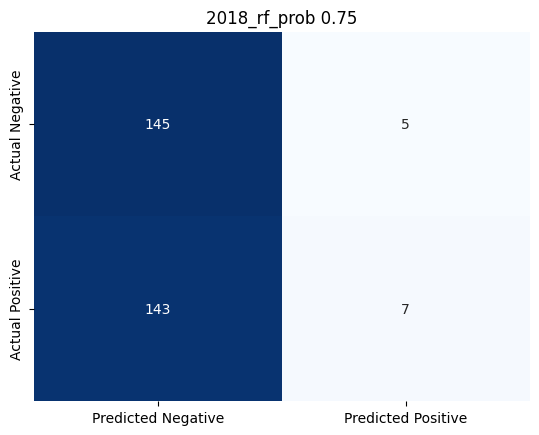

<Figure size 800x600 with 0 Axes>

Accuracy: 0.5833333333333334
Precision: 0.6470588235294118
Recall: 0.36666666666666664


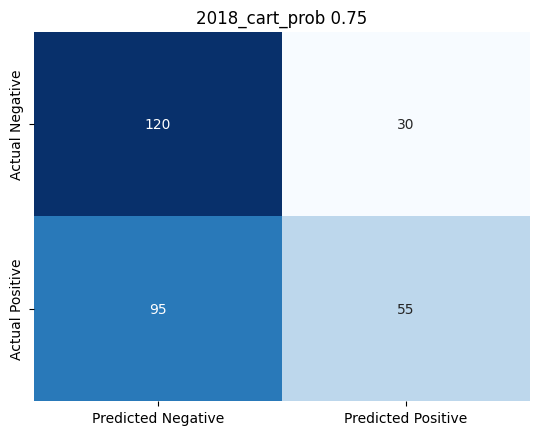

<Figure size 800x600 with 0 Axes>

Accuracy: 0.5
Precision: nan
Recall: 0.0


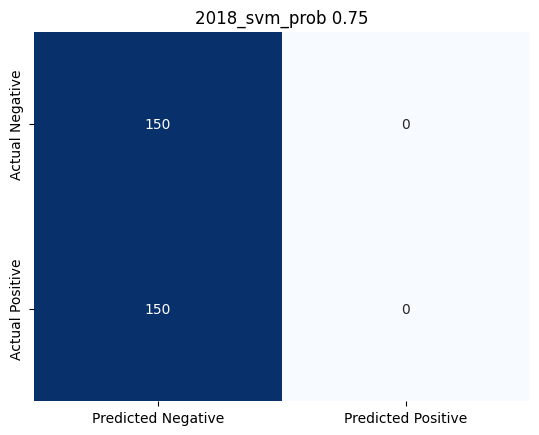

<Figure size 800x600 with 0 Axes>

In [ ]:
# 2018
file_names = ["2018_rf_prob", "2018_cart_prob", "2018_svm_prob"]
thresholds = [0.75]  # High / Very High Risk

for file_name in file_names:
    for threshold in thresholds:
        plot_confusion_matrix_given_threshold(file_name, threshold)

In [ ]:
# For area calculations
def get_area_of_region(img: ee.Image) -> float:
    pixelArea = ee.Image.pixelArea()

    unmaskedArea = pixelArea.updateMask(img.mask()).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=img.geometry(), scale=300, maxPixels=1e10
    )

    area_in_square_meters = unmaskedArea.get("area").getInfo()
    return area_in_square_meters / (1 * 10**6)

In [ ]:
# Get area of region with high likelihood of fire and total area of forest
def get_area_risk_stats(
    image_current_probs: ee.image, min: float, max: float, name: str
) -> None:
    image = image_current_probs.select("classification")
    mask = image.gt(min).And(image.lte(max))
    masked_image_current_probs = image_current_probs.updateMask(mask)

    area_in_square_kilometers_total = get_area_of_region(image_current_probs)
    area_in_square_kilometers_fire = get_area_of_region(masked_image_current_probs)

    print(
        f"% of Forest at {name} Risk: {(area_in_square_kilometers_fire / area_in_square_kilometers_total) * 100}%\n\n"
    )

In [ ]:
# Get area of region with high likelihood of fire and total area of forest
def get_area_burned_stats(
    image_current_probs: ee.image, min: float, max: float, name: str
) -> None:
    image = image_current_probs.select("Burned")
    mask = image.gt(min).And(image.lte(max))
    masked_image_current_probs = image_current_probs.updateMask(mask)

    area_in_square_kilometers_total = get_area_of_region(image_current_probs)
    area_in_square_kilometers_fire = get_area_of_region(masked_image_current_probs)

    print(
        f"Total California Forested Area Analyzed (km^2): {area_in_square_kilometers_total}"
    )
    print(f"California Burned Area in {name} (km^2): {area_in_square_kilometers_fire}")
    print(
        f"% of Burned Area in {name} (km^2): {(area_in_square_kilometers_fire / area_in_square_kilometers_total) * 100}%\n\n"
    )

In [ ]:
# rf_prob_map_2016_ventura
# rf_prob_map_2018_ventura
# burned_2017_ventura


mask = burned_2017_ventura.eq(1)
masked_image_2016 = rf_prob_map_2016_ventura.updateMask(mask)
masked_image_2018 = rf_prob_map_2018_ventura.updateMask(mask)

In [ ]:
get_area_burned_stats(burned_2017_ventura, 0.99, 1.01, "2017")

In [ ]:
get_area_risk_stats(masked_image_2016, 0.75, 1, "Very High")
get_area_risk_stats(masked_image_2016, 0.5, 0.75, "High")
get_area_risk_stats(masked_image_2016, 0.25, 0.5, "Medium")
get_area_risk_stats(masked_image_2016, 0.0, 0.25, "Low")

In [ ]:
get_area_risk_stats(masked_image_2018, 0.75, 1, "Very High")
get_area_risk_stats(masked_image_2018, 0.5, 0.75, "High")
get_area_risk_stats(masked_image_2018, 0.25, 0.5, "Medium")
get_area_risk_stats(masked_image_2018, 0.0, 0.25, "Low")

In [ ]:
get_area_burned_stats(img_output_2016, 0.99, 1.01, "2016")
get_area_burned_stats(img_output_2018, 0.99, 1.01, "2018")

In [ ]:
# 2016 CART
get_area_risk_stats(cart_prob_map_2016, 0.75, 1, "Very High")
get_area_risk_stats(cart_prob_map_2016, 0.5, 0.75, "High")
get_area_risk_stats(cart_prob_map_2016, 0.25, 0.5, "Medium")
get_area_risk_stats(cart_prob_map_2016, 0.0, 0.25, "Low")

In [ ]:
# 2016 RF
get_area_risk_stats(rf_prob_map_2016, 0.75, 1, "Very High")
get_area_risk_stats(rf_prob_map_2016, 0.5, 0.75, "High")
get_area_risk_stats(rf_prob_map_2016, 0.25, 0.5, "Medium")
get_area_risk_stats(rf_prob_map_2016, 0.0, 0.25, "Low")

In [ ]:
# 2016 SVM
get_area_risk_stats(svm_prob_map_2016, 0.75, 1, "Very High")
get_area_risk_stats(svm_prob_map_2016, 0.5, 0.75, "High")
get_area_risk_stats(svm_prob_map_2016, 0.25, 0.5, "Medium")
get_area_risk_stats(svm_prob_map_2016, 0.0, 0.25, "Low")

In [ ]:
# 2018 CART
get_area_risk_stats(cart_prob_map_2018, 0.75, 1, "Very High")
get_area_risk_stats(cart_prob_map_2018, 0.5, 0.75, "High")
get_area_risk_stats(cart_prob_map_2018, 0.25, 0.5, "Medium")
get_area_risk_stats(cart_prob_map_2018, 0.0, 0.25, "Low")

In [ ]:
# 2018 RF
get_area_risk_stats(rf_prob_map_2018, 0.75, 1, "Very High")
get_area_risk_stats(rf_prob_map_2018, 0.5, 0.75, "High")
get_area_risk_stats(rf_prob_map_2018, 0.25, 0.5, "Medium")
get_area_risk_stats(rf_prob_map_2018, 0.0, 0.25, "Low")

In [ ]:
# 2018 SVM
get_area_risk_stats(svm_prob_map_2018, 0.75, 1, "Very High")
get_area_risk_stats(svm_prob_map_2018, 0.5, 0.75, "High")
get_area_risk_stats(svm_prob_map_2018, 0.25, 0.5, "Medium")
get_area_risk_stats(svm_prob_map_2018, 0.0, 0.25, "Low")

In [ ]:
# Current rf_prob_map_current
get_area_risk_stats(rf_prob_map_current, 0.75, 1, "Very High")
get_area_risk_stats(rf_prob_map_current, 0.5, 0.75, "High")
get_area_risk_stats(rf_prob_map_current, 0.25, 0.5, "Medium")
get_area_risk_stats(rf_prob_map_current, 0.0, 0.25, "Low")

In [ ]:
# Get Feature Importance From Model
def plot_feature_importance_formatted(
    classifier: ee.Classifier, name: str, folder_name: str, png_path: str
) -> None:

    importance_dict = classifier.explain().getInfo()["importance"]

    # Turn into pandas df for plotting
    df = pd.DataFrame(list(importance_dict.items()), columns=["Feature", "Importance"])

    # Normalize and Clean
    df["Importance"] = df["Importance"] / df["Importance"].sum()
    df = df.sort_values(by="Importance", ascending=False)
    df["Feature"] = df["Feature"].map(INPUT_LABEL_MAPPING)

    # Chart Feature
    plt.figure(figsize=(8, 4))
    sns.barplot(x="Feature", y="Importance", data=df, palette="pastel")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Importance")
    plt.title(name + " Normalized Feature Importance")
    plt.savefig(
        f"/content/drive/MyDrive/{folder_name}/{png_path}.png",
        format="png",
        bbox_inches="tight",
        pad_inches=0.2,
    )

In [ ]:
plot_feature_importance_formatted(
    cart_classifier, "CART", "Thesis", "cart_classifier_feature_importance"
)

In [ ]:
plot_feature_importance_formatted(
    rf_classifier, "RF", "Thesis", "rf_classifier_feature_importance"
)